# Baseline Model Using EfficientNet B0

Here I am using transfer learning to adapt the Efficient CNN to my dataset. 

## Import Dependencies

Start by importing the dependencies for this notebook:

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models 
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential

## Preprocessing

In this section I am going to load in the data and assign it to a dictionary called food_ims.

### Load Data

Here I can again access my pickled dataset:

In [3]:
saved_path = "/Users/harrymckinney/Desktop/SavedArrays/FinalSet.npz"

In [4]:
loaded_data = np.load(saved_path, allow_pickle=True)

I want to load it into a dictionary called food_ims

In [10]:
food_ims = dict()

for key in loaded_data.keys():
    
        food_ims[key] = loaded_data[key]
        print(f"Successfully loaded {key} into dictionary")

Successfully loaded Apple into dictionary
Successfully loaded Egg into dictionary
Successfully loaded Onion into dictionary
Successfully loaded Cucumber into dictionary
Successfully loaded Cheese into dictionary
Successfully loaded Watermelon into dictionary
Successfully loaded Pasta into dictionary
Successfully loaded Bread into dictionary
Successfully loaded Banana into dictionary
Successfully loaded Pepper into dictionary
Successfully loaded Tomato into dictionary
Successfully loaded Orange into dictionary
Successfully loaded Carrot into dictionary
Successfully loaded Beans into dictionary
Successfully loaded Grapes into dictionary
Successfully loaded Kiwi into dictionary


I want to make two arrays:
1. X, the independent variables which are essentially ordered pixel values in the shape (224,224,3)
2. y, the target variables which are the class labels.

In [11]:
all_images = []
all_labels = []

for class_label, image_list in food_ims.items():
    
    all_images.extend(image_list)
    all_labels.extend([class_label] * len(image_list))

# Convert to NumPy arrays
X = np.array(all_images)
y = np.array(all_labels)

I want to do a quick sanity check to make sure the arrays are in the correct formart.

In [12]:
# Sanity Check
print(f"The entire dataset has shape: {X.shape}")
print(f"The labels have shape: {y.shape}")

The entire dataset has shape: (3281, 224, 224, 3)
The labels have shape: (3281,)


### Encoding and Train/Test Split

I need to use the sklearn LabelEncoder to change the class names from strings into numeric values. This is a convenient way for me to keep track of the categorical variable names and I can use an inverse transform of this encoder when evaluating my model later on to make the results more interpretable.

I am also going to train/test split here using 80%-20%.

In [44]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and validation (80%-20%)
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify = y_encoded)

In [45]:
# Sanity Check
print("Number of Images in Train Set")
print("-------------------------------")
print(f"X: {X_train.shape[0]} and y: {y_train.shape[0]}")
print("\nNumber of Images in Validation Set")
print("-------------------------------")
print(f"X: {X_val.shape[0]} and y: {y_val.shape[0]}")

Number of Images in Train Set
-------------------------------
X: 2624 and y: 2624

Number of Images in Validation Set
-------------------------------
X: 657 and y: 657


### Image Generator

In [41]:
# Set up ImageDataGenerator for data augmentation
# Normalization is NOT needed, it is part of the EfficientNetB0 convolution layers
datagen = ImageDataGenerator( 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Create the data generators that are used to augment my dataset. The objects train_datagen and val_datagen are passed in as paramters when I fit the model later in this notebook.

In [42]:
# Create data generators for training and validation
batch = 32
train_datagen = datagen.flow(X_train, y_train, batch_size=batch, shuffle=True)
val_datagen = datagen.flow(X_val, y_val, batch_size=batch, shuffle=False)

I need to calculate the stepsize to pass into the steps_per_epoch parameter when I fit the model.

In [43]:
# Saving the number of stepsizes for the training and validation sets
train_stepsize = len(X_train) // batch
valid_stepsize = len(X_val) // batch

# Sanity check
print(f'Training step size = {train_stepsize} \nValidation step size = {valid_stepsize}')

Training step size = 82 
Validation step size = 10


Here I import the pre-trained base layers of the convolutional neural network. The network has been trained on the imagenet dataset and allows me to avoid training the model from scratch to identify feature vectors. 

## Modelling

In [18]:
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

2023-12-14 11:52:42.419343: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In order to take advantage of the pretrained model I need to freeze the weights to prevent backpropogation through the base layers:

In [19]:
base_model.trainable = False

### Base Model Architecture

In [20]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

### Custom Model Architecture

This is where I customize the fully connected layers of the model to make predictions on my dataset. 

In [21]:
model = models.Sequential()

# Base Model
model.add(base_model)

# Top Layers
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

I can allow the training to be cut short by defining this early stopping function.

In [22]:
# Initiate early stop based on validation accuracy
ES = EarlyStopping(monitor='val_accuracy', patience=5, mode='auto', min_delta=0.0001, verbose=1)

Finally I can compile the model and summarize the architecture.

In [23]:
# Compile the model (you may need to adjust the loss function and metrics based on your specific task)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                4112      
                                                                 
Total params: 4,381,619
Trainable params: 332,048
Non-trainable params: 4,049,571
________________________________________

### Fit Model

I am going to fit the model using the data augmentation generators and the step sizes defined earlier. I will also train to a maximum of ten epochs if there is no early stopping.

In [25]:
# Train the model using the data generator and validate on the validation set
history = model.fit(train_datagen,
                    steps_per_epoch=train_stepsize, 
                    epochs=10,
                    validation_data=val_datagen,
                    validation_steps=valid_stepsize, 
                    callbacks=[ES])

Epoch 1/10
82/82 [==============================] - 151s 2s/step - loss: 0.5389 - accuracy: 0.8598 - val_loss: 0.0818 - val_accuracy: 0.9875
Epoch 2/10
82/82 [==============================] - 134s 2s/step - loss: 0.0768 - accuracy: 0.9832 - val_loss: 0.0456 - val_accuracy: 0.9937
Epoch 3/10
82/82 [==============================] - 135s 2s/step - loss: 0.0485 - accuracy: 0.9901 - val_loss: 0.0349 - val_accuracy: 0.9922
Epoch 4/10
82/82 [==============================] - 173s 2s/step - loss: 0.0368 - accuracy: 0.9920 - val_loss: 0.0400 - val_accuracy: 0.9906
Epoch 5/10
82/82 [==============================] - 193s 2s/step - loss: 0.0350 - accuracy: 0.9920 - val_loss: 0.0289 - val_accuracy: 0.9906
Epoch 6/10
82/82 [==============================] - 187s 2s/step - loss: 0.0336 - accuracy: 0.9912 - val_loss: 0.0420 - val_accuracy: 0.9906
Epoch 7/10
82/82 [==============================] - 191s 2s/step - loss: 0.0286 - accuracy: 0.9909 - val_loss: 0.0214 - val_accuracy: 0.9922
Epoch 00007: 

### Model Evaluation

In [27]:
train_time = (151+134+135+173+193+187+191)/60
print(f"The training time is {round(train_time,2)} minutes.")

The training time is 19.4 minutes.


A more concise look at the loss and accuracies for the training and validation can be called using the history method.

In [28]:
history.history

{'loss': [0.5388501286506653,
  0.0768166035413742,
  0.048472754657268524,
  0.036812007427215576,
  0.03504263982176781,
  0.03361255303025246,
  0.028613395988941193],
 'accuracy': [0.8597561120986938,
  0.9832317233085632,
  0.9900914430618286,
  0.9919969439506531,
  0.9919969439506531,
  0.9912347793579102,
  0.9908536672592163],
 'val_loss': [0.08183098584413528,
  0.045593418180942535,
  0.03488332778215408,
  0.0399918332695961,
  0.028947755694389343,
  0.04202422872185707,
  0.02138437330722809],
 'val_accuracy': [0.987500011920929,
  0.9937499761581421,
  0.9921875,
  0.9906250238418579,
  0.9906250238418579,
  0.9906250238418579,
  0.9921875]}

Can make use of this information by plotting these metrics using plots.

#### Loss and Accuracy Plots

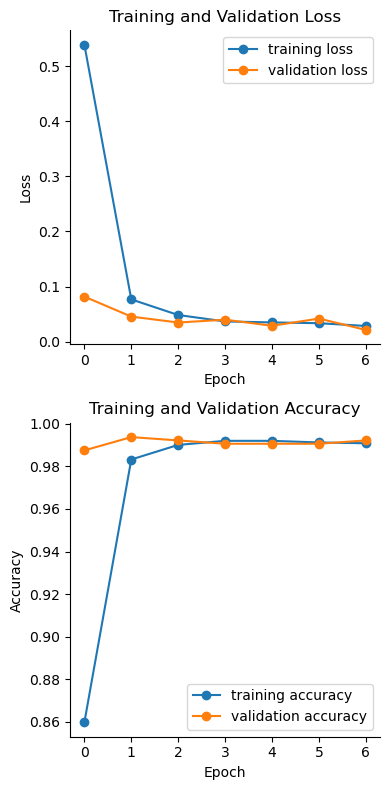

In [48]:
plt.subplots(2,1,figsize =(4,8))

plt.subplot(2,1,1)
plt.plot(history.history['loss'], marker='o', label='training loss')
plt.plot(history.history['val_loss'], marker='o', label='validation loss')
plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2,1,2)
plt.plot(history.history['accuracy'], marker='o', label='training accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

sns.despine()
plt.tight_layout()
plt.show()

#### Confusion Matrix

In order to make predictions I need to get the predictions from the model:

In [30]:
# Make predictions
predictions = model.predict(val_datagen)

In [31]:
predicted_labels = np.argmax(predictions, axis=1)

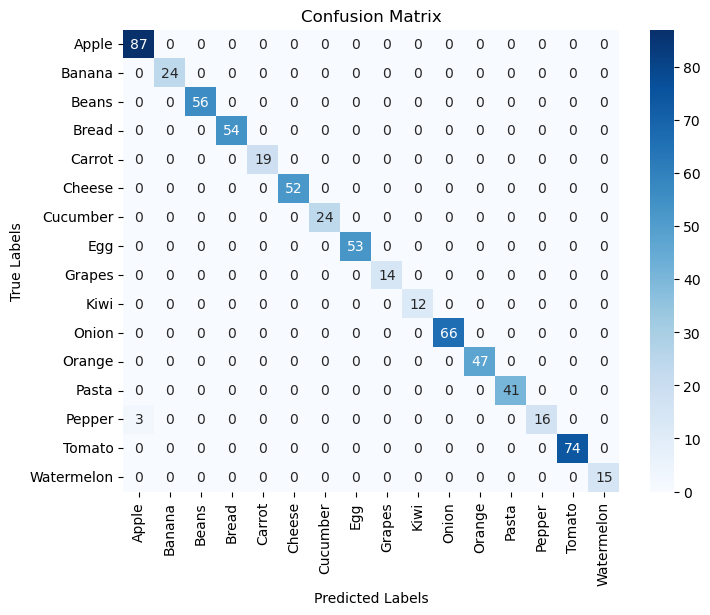

In [32]:
# Decode labels
decoded_predicted_labels = label_encoder.inverse_transform(predicted_labels)
decoded_true_labels = label_encoder.inverse_transform(y_val)

# Create and visualize confusion matrix
cm = confusion_matrix(decoded_true_labels, decoded_predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [35]:
print(classification_report(decoded_true_labels, decoded_predicted_labels))

              precision    recall  f1-score   support

       Apple       0.97      1.00      0.98        87
      Banana       1.00      1.00      1.00        24
       Beans       1.00      1.00      1.00        56
       Bread       1.00      1.00      1.00        54
      Carrot       1.00      1.00      1.00        19
      Cheese       1.00      1.00      1.00        52
    Cucumber       1.00      1.00      1.00        24
         Egg       1.00      1.00      1.00        53
      Grapes       1.00      1.00      1.00        14
        Kiwi       1.00      1.00      1.00        12
       Onion       1.00      1.00      1.00        66
      Orange       1.00      1.00      1.00        47
       Pasta       1.00      1.00      1.00        41
      Pepper       1.00      0.84      0.91        19
      Tomato       1.00      1.00      1.00        74
  Watermelon       1.00      1.00      1.00        15

    accuracy                           1.00       657
   macro avg       1.00   

List of Hyperparameters to tune:

- Class imbalance (Separate Data Generator for minority class that is more aggressive, oversampling/undersampling)
- Train/Validation Size
- Datagen settings
- Basemodel
- Layers:
    - model.add(layers.GlobalAveragePooling2D()) 
    - model.add(layers.Dense(256, activation='relu'))
    - model.add(layers.Dropout(0.5))
    - model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))
- optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']